# Test notes for phase transitions of ALP

This notebook record some of my tests during writing the main python file. I try my best to organize it and make it readable, but it's not guaranteed.

## Preparison

Import packages, define physical constants, etc

In [6]:
import numpy as np
from cosmoTransitions import generic_potential as gp
from matplotlib import pyplot as plt
from cosmoTransitions import pathDeformation as pd
from cosmoTransitions.tunneling1D import SingleFieldInstanton
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from scipy import interpolate
from scipy import optimize
from cosmoTransitions import helper_functions
from finiteT import Jb_spline as Jb
from finiteT import Jf_spline as Jf
from cosmoTransitions.finiteT import Jb_exact2 as Jbe
from cosmoTransitions.finiteT import Jf_exact2 as Jfe
from collections import namedtuple
import csv

In [2]:
mZEW = 91.1876
GF = 1.1663787e-05
v = (2**0.5 * GF)**(-0.5)/np.sqrt(2)
v2 = v**2
mhpole = 125.13
g1 = 0.3573944734603928
g2 = 0.6510161183564389
yt = 0.9777726923522626

In [3]:
v # Make sure to use this convention

174.10358473791823

## Finite temperature integral

Test the finite temperature integral $J_b$ and $J_f$.

/Users/quarkquartet/opt/anaconda3/lib/python3.9/site-packages/cosmoTransitions/finiteT.py:88: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(f1, 0, abs(theta)**.5)[0]
/Users/quarkquartet/opt/anaconda3/lib/python3.9/site-packages/cosmoTransitions/finiteT.py:88: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate.quad(f1, 0, abs(theta)**.5)[0]


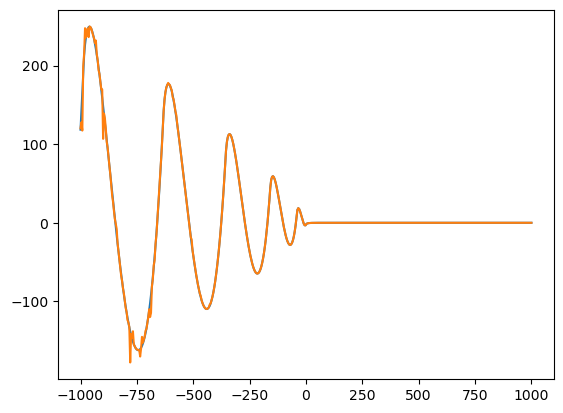

In [64]:
x_list = np.linspace(-1000,1000, 500)
Jblist = Jb(x_list)
Jbelist = Jbe(x_list)
plt.plot(x_list,Jblist)
plt.plot(x_list,Jbelist)

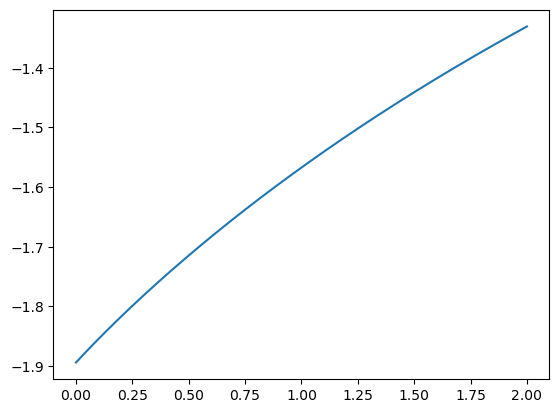

In [230]:
x_list = np.linspace(0,2,300)
y_list = Jf(x_list)
plt.plot(x_list,y_list)

## Comparison of interpolation methods

Just for a personal learning. Understand different interpolation method of python

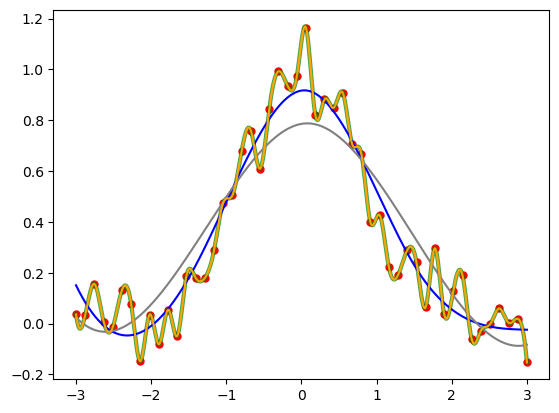

In [ ]:
rng = np.random.default_rng()

x = np.linspace(-3, 3, 50)

y = np.exp(-x**2) + 0.1 * rng.standard_normal(50)

spl = InterpolatedUnivariateSpline(x, y)
smooth1 = UnivariateSpline(x,y, s=0.5)
smooth2 = UnivariateSpline(x,y, s=1.0)
int1d = interp1d(x,y, 'cubic')

plt.plot(x, y, 'ro', ms=5)

xs = np.linspace(-3, 3, 1000)

plt.plot(xs, spl(xs), 'g', lw=3, alpha=0.7)
plt.plot(xs, smooth1(xs), 'b')
plt.plot(xs, smooth2(xs), 'gray')
plt.plot(xs, int1d(xs), 'orange')

plt.show()

## Class

Define the effective potential class. This should be the same as the main `ALP.py`. If not, use that one.

In [45]:
class model_ALP(gp.generic_potential):
    """
    Class of CosmoTransitions. Input parameters are the 1-loop renormalized
    parameters (but not the directly-observed quantites such as mixing angle or mass).

    Parameters include:
    lh: Higgs quartic coupling.
    A: Higgs-ALP coupling.
    muHsq: Higgs mass term squared.
    muSsq: ALP mass term squared.
    f: scale parameter for the ALP, i.e. the "decay constant" of the axion. Could
    be understood as the UV-completion scale.
    beta: phase difference between the ALP mass term and the Higgs-ALP interaction term.

    Effective potential of the model, and some defined functions for computation.
    """

    def init(self, mS, sintheta, lh, A, muHsq, muSsq, f, delta):
        self.Ndim = 2
        self.g1 = g1
        self.g2 = g2
        self.yt = yt
        self.mS = mS
        self.sintheta = sintheta
        self.lh = lh
        self.A = A
        self.muHsq = muHsq
        self.muSsq = muSsq
        self.f = f
        self.delta = delta
        self.Tmax = 200
        self.Tmin = 20
        self.renormScaleSq = mZEW**2
        self.Tc = None
        self.action_trace_data = None
        self.Tn = None
        self.action_trace_data_1d = None
        self.Tn1d = None
        self.Tcvev = None
        self.strength_Tc = None

    def V0(self, X):
        """Tree-level potential."""

        # Define field variable quantities
        X = np.asanyarray(X)
        assert X.shape[-1] == 2

        h = X[..., 0]
        S = X[..., 1]

        # tree-level potential
        y_h = (
            -0.5 * (self.muHsq - self.A * self.f * np.cos(self.delta)) * h**2
            + 0.25 * self.lh * h**4
        )

        y_S = -self.f**2 * self.muSsq * (np.cos(S / self.f) - 1)

        y_hS = (
            -0.5
            * self.A
            * self.f
            * (h**2 - 2 * v2)
            * np.cos(-self.delta + S / self.f)
        )

        tot = y_h + y_S + y_hS

        return tot

    def boson_massSq(self, X, T):
        """
        Method of CosmoTransitions. Returns bosons mass square, dof and constants. The scalar masses are the eigenvalues of the full physical scalar matrix, plus the Nambu-Goldstone bosons.
        """

        X = np.array(X)
        T = np.asanyarray(T, dtype=float)
        T2 = T * T
        assert X.shape[-1] == 2
        h = X[..., 0]
        S = X[..., 1]

        mgs = (
            self.lh * h**2
            - self.muHsq
            - self.A * self.f * np.cos(S / self.f - self.delta)
            + self.A * self.f * np.cos(self.delta)
        ) 

        # Scalar mass matrix ((a,c),(c,b))
        aterm = (
            3 * self.lh * h**2
            - self.muHsq
            - self.A * self.f * np.cos(S / self.f - self.delta)
            + self.A * self.f * np.cos(self.delta)
        ) 

        cterm = -self.A * h * np.sin(S / self.f - self.delta)

        bterm = 0.5 * (
            self.A * (h**2 - 2 * v2 + T2/3) * np.cos(-self.delta + S / self.f)
        ) / self.f + self.muSsq * np.cos(S / self.f)

        # Scalar eigenvalues
        mhsq = 0.5 * (aterm + bterm + np.sqrt((aterm - bterm) ** 2 + 4 * cterm**2))
        mSsq = 0.5 * (aterm + bterm - np.sqrt((aterm - bterm) ** 2 + 4 * cterm**2))

        mW = 0.25 * self.g2**2 * h**2
        mWL = mW 
        mZ = 0.25 * (self.g2**2 + self.g1**2) * h**2

        AZsq = 0

        mZL = mZ
        mAL = 0

        M = np.array([mSsq, mhsq, mgs, mW, mWL, mZ, mZL, mAL])
        M = np.rollaxis(M, 0, len(M.shape))

        dof = np.array([1, 1, 3, 4, 2, 2, 1, 1])
        c = np.array([1.5, 1.5, 1.5, 0.5, 1.5, 0.5, 1.5, 1.5])

        return M.real + 1e-16, dof, c

    def fermion_massSq(self, X):
        """
        Method of CosmoTransitions. Fermion mass square. Only top quark is included.
        """

        X = np.array(X)
        h = X[..., 0]

        mt = 0.5 * self.yt**2 * h**2
        Mf = np.array([mt])
        Mf = np.rollaxis(Mf, 0, len(Mf.shape))

        doff = np.array([12.0])

        return Mf, doff

#     def V1(self, bosons, fermions, scale=mZEW):
#         """
#         Method of CosmoTransitions. Overwritten.
# 
#         The 1-loop CW correction at the zero-temperature in the
#         MS-bar renormalization scheme.
#         """
# 
#         scale2 = scale**2
#         m2, n, c = bosons
#         y = np.sum(n * m2 * m2 * (np.log(m2 / scale2 + 1e-100 + 0j) - c), axis=-1)
#         m2, n = fermions
#         c = 1.5
#         y -= np.sum(n * m2 * m2 * (np.log(m2 / scale2 + 1e-100 + 0j) - c), axis=-1)
#         return y.real / (64 * np.pi * np.pi)

#     def V0T(self, X):
#         """
#         1-loop corrected effective potential at T=0.
#         Not an intrinsic method of CosmoTransitions.
#         """
#         X = np.asanyarray(X, dtype=float)
# 
#         bosons = self.boson_massSq(X, 0)
#         fermions = self.fermion_massSq(X)
# 
#         y = self.V0(X)
#         y += self.V1(bosons, fermions)
# 
#         return y

    def V1T(self, bosons, fermions, T, include_radiation=True):
        """
        Method of CosmoTransitions. Should be overwritten.
        The 1-loop finite-temperature correction term.

        `Jf` and `Jb` are modified functions.

        TODO: understand this again, write note, and implement it.
        """

        T2 = (T * T) + 1e-100
        T4 = T2 * T2

        m2, nb, _ = bosons
        y = np.sum(nb * Jb(m2 / T2), axis=-1)
        m2, nf = fermions
        y += np.sum(nf * Jf(m2 / T2), axis=-1)

        return y * T4 / (2 * np.pi * np.pi)

    def Vtot(self, X, T, include_radiation=True):
        """
        Method of CosmoTransitions.
        The total finite temperature effective potential.
        """

        T = np.asanyarray(T, dtype=float)
        X = np.asanyarray(X, dtype=float)
        assert X.shape[-1] == 2

        bosons = self.boson_massSq(X, T)
        fermions = self.fermion_massSq(X)
        Vtot = self.V0(X)
        # Vtot += self.V1(bosons, fermions)
        Vtot += self.V1T(bosons, fermions, T, include_radiation)

        return Vtot

    """
    So far we have computed the finite temperature effective potential.
    Move on to compute the relevant quantities in during the phase transition.
    """

    def getTc(self):
        """
        Find the critical temperature, using binormial search.
        """
        num_i = 30
        Tmax = self.Tmax
        Tmin = self.Tmin
        T_test = (Tmax + Tmin) * 0.5
        print("Finding Tc...")
        for i in range(num_i + 10):
            h_range = np.linspace(0, 300, 300)
            V_range = np.array([self.Vmin(i, T_test) for i in h_range])
            V1dinter = interpolate.UnivariateSpline(h_range, V_range, s=0)
            xmin = optimize.fmin(V1dinter, 200, disp=False)[0]
            # print("T = " + str(T_test))
            # print("xmin = " + str(xmin))
            if V1dinter(xmin) < V1dinter(0) and xmin > 1:
                if i > num_i:
                    self.Tc = T_test
                    self.Tcvev = xmin
                    self.strength_Tc = xmin / T_test
                    break
                else:
                    Tmin = T_test
                    Tnext = (Tmax + T_test) * 0.5
                    T_test = Tnext
            #   print("T too low!")
            else:
                Tmax = T_test
                Tnext = (Tmin + T_test) * 0.5
                T_test = Tnext
                # print("T too high!")

    def Vmin(self, h, T):
        T2 = T**2
        # Write down the high-T expanded one as the initial guess.
        num = self.A * (3 * (h**2 - 2 * v**2) + T2) * np.sin(self.delta)
        den = 6 * self.f * self.muSsq + self.A * (
            3 * (h**2 - 2 * v**2) + T2
        ) * np.cos(self.delta)
        highT_path = self.f * np.arctan(num / den)
        y = optimize.minimize(
            self.Vtot,
            x0=np.array([h, highT_path]),
            args=(T,),
            method="Nelder-Mead",
            bounds=[(h, h), (-self.f * np.pi, self.f * np.pi)],
        ).fun
        return y

    def Smin(self, h, T):
        T2 = T**2
        # Write down the high-T expanded one as the initial guess.
        num = self.A * (3 * (h**2 - 2 * v**2) + T2) * np.sin(self.delta)
        den = 6 * self.f * self.muSsq + self.A * (
            3 * (h**2 - 2 * v**2) + T2
        ) * np.cos(self.delta)
        highT_path = self.f * np.arctan(num / den)
        y = optimize.minimize(
            self.Vtot,
            x0=np.array([h, highT_path]),
            args=(T,),
            method="Nelder-Mead",
            bounds=[(h, h), (-self.f * np.pi, self.f * np.pi)],
        ).x[1]
        return y 

## $T=0$ stability

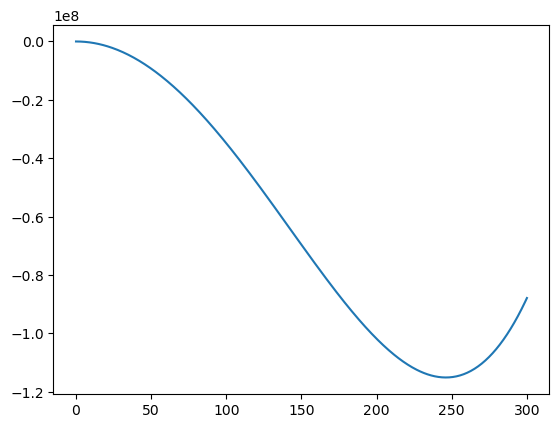

In [4]:
model = model_ALP(5, 0.17, 0.125559, 11.1902, 7602.87, 21.8353**2, 1e5, 2*np.pi/5)
h_list = np.linspace(0,300,500)
y_list_tree = [model.V0([i,0])-model.V0([1e-16,0]) for i in h_list]
plt.plot(h_list, y_list_tree)
# test tree-level

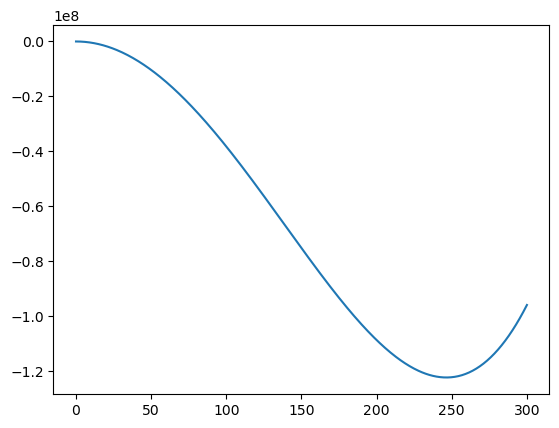

In [5]:
model = model_ALP(5, 0.17, 0.146672, 11.1836, 8607.8, 476.78, 1e5, 2*np.pi/5)
h_list = np.linspace(0,300,500)
y_list = [model.V0T([i,0])-model.V0T([0,0]) for i in h_list]
plt.plot(h_list, y_list)
# test 1-loop level

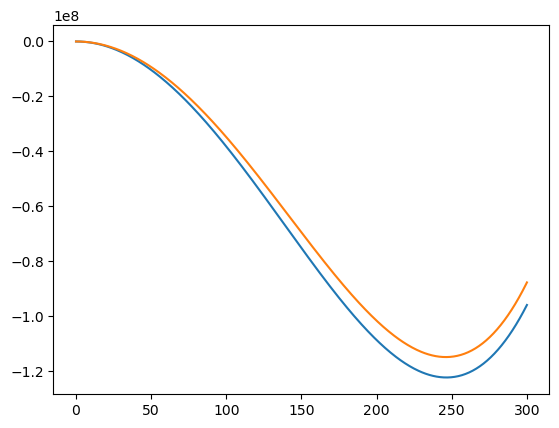

In [6]:
plt.plot(h_list, y_list)
plt.plot(h_list, y_list_tree)

## Test defined functions

In [4]:
model = model_ALP(5, 0.16, 0.14749514745168907, 10.61953003921521, 8643.793322995569, 428.1718668797098, 1e5, 2*np.pi/5)

In [5]:
model.getTc()

Finding Tc...


In [6]:
model.Tc

65.46275691653136

In [7]:
model.Smin(1e-16, model.Tc)

-702.852646487305

In [8]:
model.trace_action()

Tracing action data...
Tunneling at T = 65.45275691653136
S3/T = 18948.379075977537
Tunneling at T = 65.44775691653136
S3/T = 8775.087174620705
Tunneling at T = 65.44275691653135
S3/T = 5133.024563405399
Tunneling at T = 65.43775691653136
S3/T = 3410.0672266101988
Tunneling at T = 65.43275691653136
S3/T = 2453.9790968515626
Tunneling at T = 65.42775691653135
S3/T = 1865.3495659708055
Tunneling at T = 65.42275691653136
S3/T = 1475.409090546912
Tunneling at T = 65.41775691653136
S3/T = 1202.6208250147847
Tunneling at T = 65.41275691653135
S3/T = 1003.6239649897301
Tunneling at T = 65.40775691653135
S3/T = 853.5065081476679
Tunneling at T = 65.40275691653136
S3/T = 736.8314931738198
Tunneling at T = 65.39775691653135
S3/T = 644.1686685921825
Tunneling at T = 65.39275691653135
S3/T = 569.2485533584498
Tunneling at T = 65.38775691653136
S3/T = 507.21766171124415
Tunneling at T = 65.38275691653136
S3/T = 456.93083666204757
Tunneling at T = 65.37775691653135
S3/T = 414.53145835406195
Tunnelin

In [9]:
model.find_Tn()

Tnuc = 65.24746636394376


In [10]:
model.strength_Tn()

1.115624780438125

In [20]:
model.strength_Tn()

1.1156046932386652

In [21]:
model.beta_over_H()

87964.35675188269

In [22]:
model.alpha()

0.0027451904903771653

In [530]:
model.find_Tn_1d()

Tracing action data...
Tunneling at T = 65.4527569165091
S3/T = 18948.457742011935
Tunneling at T = 65.4507569165091
S3/T = 13380.284909475884
Tunneling at T = 65.4487569165091
S3/T = 9992.621326880966
Tunneling at T = 65.4467569165091
S3/T = 7774.280586419627
Tunneling at T = 65.4447569165091
S3/T = 6240.031981306806
Tunneling at T = 65.4427569165091
S3/T = 5132.9943444519295
Tunneling at T = 65.4407569165091
S3/T = 4306.867082535795
Tunneling at T = 65.4387569165091
S3/T = 3673.088470131301
Tunneling at T = 65.4367569165091
S3/T = 3175.734980729318
Tunneling at T = 65.4347569165091
S3/T = 2777.72702314953
Tunneling at T = 65.4327569165091
S3/T = 2453.9829727267816
Tunneling at T = 65.4307569165091
S3/T = 2186.7101705332816
Tunneling at T = 65.4287569165091
S3/T = 1963.47641198022
Tunneling at T = 65.4267569165091
S3/T = 1774.858915240885
Tunneling at T = 65.4247569165091
S3/T = 1613.9029321949733
Tunneling at T = 65.4227569165091
S3/T = 1475.3944549575654
Tunneling at T = 65.42075691

In [531]:
model.Tn1d

65.29574523116781

In [532]:
model.beta_over_H_1d()

91624.75553696993

In [533]:
model.strength_Tn_1d()

1.0820436839656504

## Minimize the potential and solve everything along 1d

In [95]:
def Vmin(x, T):
    T2 = T**2
    # Write down the high-T expanded one as the initial guess.
    num = model.A * (3 * (x**2 - 2 * v**2) + T2) * np.cos(model.beta)
    den = 6 * model.f * model.muSsq + model.A * (
        3 * (x**2 - 2 * v**2) + T2
    ) * np.sin(model.beta)
    highT_path = model.f * num / den
    y = optimize.minimize(
        model.Vtot,
        x0=np.array([x, highT_path]),
        args=(T,),
        method="Nelder-Mead",
        bounds=[(x, x), (-model.f * np.pi, model.f * np.pi)],
    ).fun
    return y

In [507]:
T_test = 65.4

65.1832983800967

In [514]:
tv = model.true_vev(T_test)[0]
x_range = np.linspace(-1.3*tv,1.3*tv,200)
V_range = np.array([Vmin(i, T_test) for i in x_range])
V1dinter = interpolate.UnivariateSpline(x_range, V_range, s=0)

Check how good is the interpolation

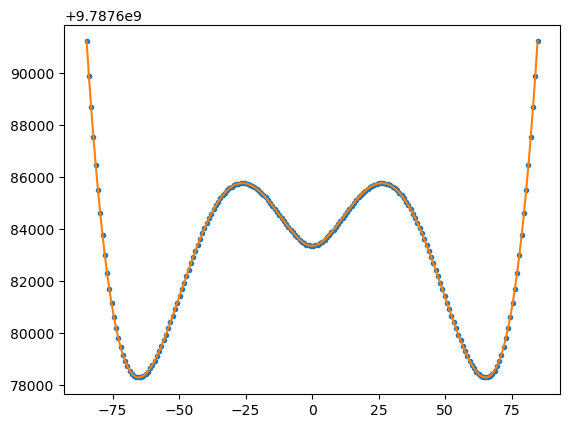

In [515]:
y_range = V1dinter(x_range)
plt.plot(x_range, V_range, ".")
plt.plot(x_range, y_range)

In [516]:
gradV = V1dinter.derivative()

In [518]:
tobj = SingleFieldInstanton(model.true_vev(T_test)[0], model.false_vev(T_test)[0], V1dinter, gradV)

In [519]:
prof=tobj.findProfile()

In [520]:
tobj.findAction(prof)/T_test

683.2165340900299

## Try other models

In [55]:
model = model_ALP(5, 0.025, 0.129209, 2.70116,7823.87,34.7703,4149.907345, np.pi/5)

In [36]:
model=model_ALP(0.1, 0.00012,	0.12929,	0.0488098,	7828.76,	0.0102255,	173422.,np.pi/20)

In [5]:
model.getTc()

Finding Tc...


In [6]:
model.strength_Tc

0.7118223543274972

In [9]:
model.Tc

79.39240747597069

Optimization terminated successfully.
         Current function value: -105449679.348092
         Iterations: 21
         Function evaluations: 42
168.98414611816406


True

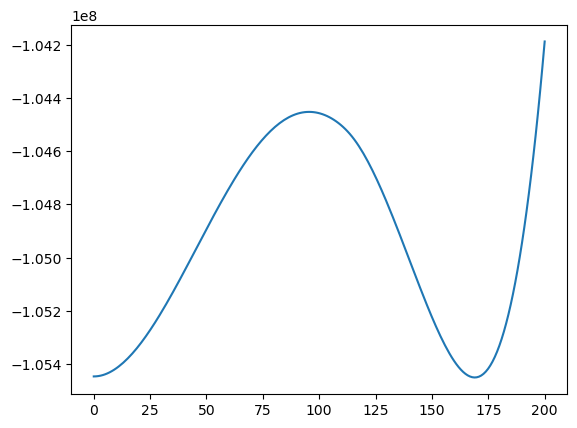

In [64]:
T_test = 103.3
h_range = np.linspace(0,200,200)
V_range = np.array([model.Vmin(i, T_test) for i in h_range])
plt.plot(h_range, V_range)
V1dinter = interpolate.UnivariateSpline(h_range, V_range, s=0)
xmin = optimize.fmin(V1dinter, 200)[0]
print(xmin)
V1dinter(xmin) < V1dinter(0)

In [40]:
108*1.2/133.5

0.9707865168539326

In [62]:
111.5/133.5

0.8352059925093633

In [14]:
model.find_Tn()

Tracing action data...
Tracing action data...
Finding Tc...
Tunneling at T = 81.8984238866344
S3/T = 34314.88045750803
Tunneling at T = 81.89342388663441
S3/T = 15717.753683561423
Tunneling at T = 81.8884238866344
S3/T = 9101.336393727554
Tunneling at T = 81.8834238866344
S3/T = 5990.165391715414
Tunneling at T = 81.87842388663441
S3/T = 4273.901543496346
Tunneling at T = 81.8734238866344
S3/T = 3223.2615809863146
Tunneling at T = 81.8684238866344
S3/T = 2531.101779714023
Tunneling at T = 81.86342388663441
S3/T = 2049.533997182059
Tunneling at T = 81.8584238866344
S3/T = 1700.0418940153666
Tunneling at T = 81.8534238866344
S3/T = 1437.7167722265071
Tunneling at T = 81.84842388663441
S3/T = 1235.343102058815
Tunneling at T = 81.8434238866344
S3/T = 1075.62697094084
Tunneling at T = 81.8384238866344
S3/T = 947.1219880973011
Tunneling at T = 81.8334238866344
S3/T = 842.0150850756806
Tunneling at T = 81.82842388663441
S3/T = 754.8343816351174
Tunneling at T = 81.8234238866344
S3/T = 681.45

In [15]:
tobj=model.tunneling_at_T(model.Tn)

Path deformation converged. 56 steps. fRatio = 1.92223e-02
Path deformation converged. 19 steps. fRatio = 1.16010e-02
Path deformation converged. 1 steps. fRatio = 6.02287e-02


In [16]:
Rlist=tobj.profile1D.R
hlist=tobj.Phi[:,0]
Slist=tobj.Phi[:,1]
Snormlist=Slist-min(Slist)

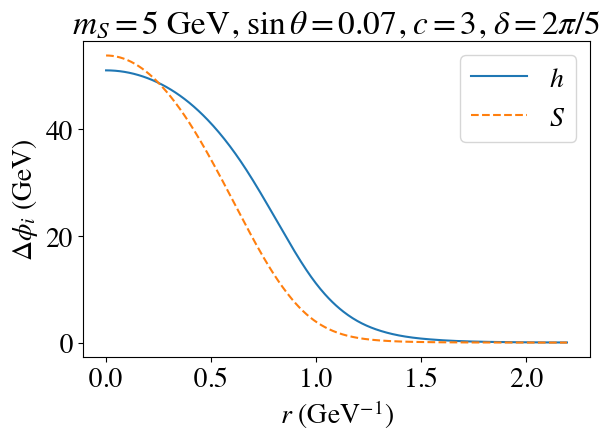

In [17]:
plt.plot(Rlist,hlist,label=r'$h$')
plt.plot(Rlist,Snormlist,linestyle='dashed',label=r'$S$')
plt.rcParams['font.family']='Times'
plt.rcParams['font.size']=20
plt.rcParams["mathtext.fontset"]='stix'
plt.rcParams.update({'figure.autolayout': True})
plt.legend(prop={'family':'Times', 'size':20})
plt.xlabel(r'$r$ (GeV$^{-1}$)')
plt.ylabel(r'$\Delta \phi_i$ (GeV)')
plt.title(r'$m_S = 5$ GeV, $\sin \theta = 0.07$, $c=3$, $\delta=2\pi/5$')
plt.subplots_adjust(bottom=0.1)
plt.savefig('output/profile.pdf',dpi=300)
plt.show()

In [34]:
model = model_ALP(1, 0.01, 0.150780999, 0.673435153, 8842.762217, 2.577784878, 23600.34364, 2*np.pi/5)

In [10]:
model.getTc()

Finding Tc...


In [12]:
model.Tc

64.85823042807169

In [39]:
model.Tcvev

150.7952880859375

In [11]:
model.strength_Tc

1.0187060567624113

Optimization terminated successfully.
         Current function value: 128626609.467899
         Iterations: 18
         Function evaluations: 36
210.89309692382812


False

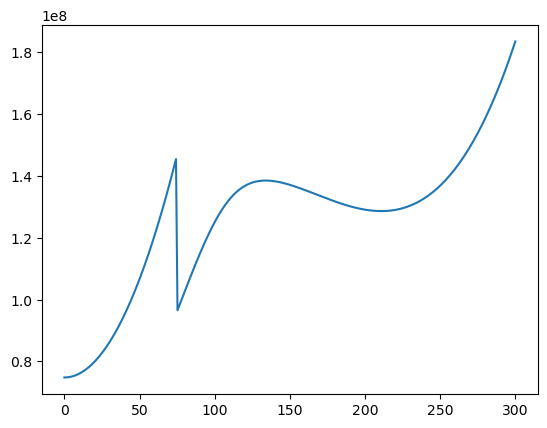

In [50]:
T_test = 100
h_range = np.linspace(0,300,300)
V_range = np.array([model.Vmin(i, T_test) for i in h_range])
plt.plot(h_range, V_range)
V1dinter = interpolate.UnivariateSpline(h_range, V_range, s=0)
xmin = optimize.fmin(V1dinter, 200)[0]
print(xmin)
V1dinter(xmin) < V1dinter(0)

In [19]:
model=model_ALP(5,0.1,0.149109,6.64228,8755.52,181.325,3168.13,np.pi*2/5)

In [20]:
model.getTc()

Finding Tc...


In [21]:
model.strength_Tc

1.0092229628782936

In [22]:
model.Tc

66.49835198651999

In [9]:
param_file="../model_setup/output/test.csv"

In [26]:
dataset=[]
with open(param_file) as csv_file:
    reader = csv.reader(csv_file)
    for i in reader:
        dataset.append(i)

In [29]:
dataset

[['0.0001',
  '0.12928983967024155',
  '0.040674846449297405',
  '7828.758371712465',
  '0.010156575069231621',
  '56902.4324554453'],
 ['0.00011',
  '0.12928983939873304',
  '0.0447423310472477',
  '7828.758355272083',
  '0.010189455833824468',
  '62390.69281436284'],
 ['0.00012',
  '0.1292898391013666',
  '0.04880981563177529',
  '7828.75833726595',
  '0.010225468099633872',
  '67822.86971545302'],
 ['0.00013000000000000002',
  '0.1292898387781422',
  '0.05287730020165994',
  '7828.758317694066',
  '0.010264611866659834',
  '73194.58174162259'],
 ['0.00014000000000000001',
  '0.12928983842905986',
  '0.056944784755681405',
  '7828.758296556432',
  '0.010306887135811849',
  '78501.62159075687'],
 ['0.00015000000000000001',
  '0.12928983805411956',
  '0.06101226929261944',
  '7828.758273853047',
  '0.010352293905270926',
  '83739.96553786998']]

In [27]:
strengthlist=[]
for point in dataset:
    md=model_ALP(0.1, point[0],point[1], point[2], point[3], point[4], point[5], np.pi/20)
    model.getTc()
    strengthlist.append(1.2*model.strength_Tc)

Finding Tc...
Finding Tc...
Finding Tc...
Finding Tc...
Finding Tc...
Finding Tc...


KeyboardInterrupt: 

In [28]:
strengthlist

[0.7823114391930962,
 0.7823114391930962,
 0.7823114391930962,
 0.7823114391930962,
 0.7823114391930962]